# Feature Engineering and Preprocessing

Firstly we'll drop features as we did in EDA, then encode where necessary, and then engineer if any features available.

After that we'll try a multitude of models to select the best performing model (likely using AUC). I expect I will experiment with:

* Decision Tree
* Random Forest
* XGBoost
* Logistic Regression
* SVM (Cost Penalising)

Another thought here before we get into the model is what should be we prioritising?

* Precision; or
* Recall?

And also what matters more to us?

* Reducing False Positives
* Reducing False Negatives

I think in this use-case it really depends on the policy that will be implemented after the model, i.e. if it is simply
to start a conversation, then probably optimisation of both precision, recall.

However, if the policy is more expensive (i.e. we'll give payrises to those who leave, more flexibility in leave time) then we'd wnat to reduce the false positive even if it results in a larger amount of false negatives.

In [1]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ML imports

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
import xgboost

In [2]:
df_main = pd.read_csv('HR-Employee-Attrition.csv')

In [3]:
df_main.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Dropping Columns (same as EDA)

In [4]:
df_main.drop(labels=['EmployeeCount', 'EmployeeNumber','StandardHours','Over18'], axis=1,inplace=True)

### Dropping Additional Columns (from Correlation Matrix)

In [5]:
df_main.drop(labels=['YearsAtCompany', 'JobLevel'],axis=1,inplace=True)

In [6]:
len(df_main.columns)

29

### Encode categorical data

In [7]:
categorical_data = df_main.dtypes.loc[df_main.dtypes=='object'].index

print(", ".join(categorical_data))

Attrition, BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, OverTime


In [8]:
# get dummies function in Pandas performs one hot encoding
# making sure to drop_first to avoid collinearity issues
# use on everything except BusinessTravel (as we can rank this)

# business travel

business_encode_mask = {'Attrition':{'Yes':1,'No':0},'BusinessTravel': {'Travel_Frequently':2, 'Travel_Rarely':1,'Non-Travel':150}}
df_main.replace(business_encode_mask, inplace=True)

# now let's encode everything else

categorical_data = list(categorical_data)
categorical_data.remove('BusinessTravel')
categorical_data.remove('Attrition')


df_main = pd.get_dummies(df_main,columns=categorical_data, drop_first=True)

In [9]:
# let's sense check length to make sure all encoding went through

len(df_main.columns)

42

In [10]:
# makes sense, previously 29 + 1 for attrition + 2 for department + 5 for education field + 3 for job role + 1 for marital + 1 for ot

# let's now re-name into x and y

y = df_main['Attrition']
x = df_main.drop('Attrition',axis=1)

### Data transformation

Given the different scales seen within the quantitiatve data (from rank data 0 to 5) all the way to monthly income going up to $12k, we will need to transform this data.

Once again, I have referred to <a href='https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/'> here</a>.

I will implement normalisation for this case (and if I have enough time I will run some tests against standardisation for effectiveness)

In [11]:
from sklearn.preprocessing import normalize

x = normalize(x)

### Splitting between Test and Training

Let's split between test and training datasets now that we're preprocessed.


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.25, random_state=2)  
print("Number records X_train dataset: ", X_train.shape)
print("Number records y_train dataset: ", y_train.shape)
print("Number records X_test dataset: ", X_test.shape)
print("Number records y_test dataset: ", y_test.shape)

Number records X_train dataset:  (1102, 41)
Number records y_train dataset:  (1102,)
Number records X_test dataset:  (368, 41)
Number records y_test dataset:  (368,)


### Dealing with Imbalance

This is my first time dealing with imbalance so I refer to this friendly article I've reviewed <a href='https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/'>here</a>.

In summary, we try and 'rebalance' the dataset by making up fake records, either by oversampling (duplicating minority class, in this case, the leavers) or undersampling (deleting the majority class, or in this case, the non-leavers).

There is a package called 'imblearn' which uses some more sophisticated sampling techniques to rebalance.

In summary it looks like 'over-sampling' techniques generally outperform 'under-sampling' as it retains data. We will go with one called SMOTE. The article has a great write-up on it.


In [13]:
from imblearn.over_sampling import SMOTE

In [14]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Previous x shape {}. Current x shape: {}'.format(X_train.shape,X_train_smote.shape))
print('Previous y shape {}. Current y shape: {}'.format(y_train.shape,y_train_smote.shape))
print('\nPrevious y value counts: \n\n{}.\n\n Current y shape: \n\n{}'.format(y_train.value_counts(),y_train_smote.value_counts()))

Previous x shape (1102, 41). Current x shape: (1854, 41)
Previous y shape (1102,). Current y shape: (1854,)

Previous y value counts: 

0    927
1    175
Name: Attrition, dtype: int64.

 Current y shape: 

0    927
1    927
Name: Attrition, dtype: int64


# Machine Learning Models!

## Decision Tree


In [15]:
# firstly let's code in a predicting and classification function so we don't have to do over and over

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def run_model(model):
    
    model.fit(X_train_smote, y_train_smote)
    
    y_pred = model.predict(X_test)
    
    print("CLASSIFICATION REPORT")
    print("===================================================")
    print(classification_report(y_test, y_pred))
    print("CONFUSION MATRIX")
    print("===================================================")
    print(confusion_matrix(y_test, y_pred))
    
    return None

In [16]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier(max_depth = 4, random_state=2)
decision_tree.fit(X_train_smote, y_train_smote)

y_pred = decision_tree.predict(X_test)

# visualise the tree
print(tree.export_text(decision_tree, decimals=10,feature_names=list(df_main.drop('Attrition',axis=1).columns)))

|--- OverTime_Yes <= 0.0000002398
|   |--- MaritalStatus_Single <= 0.0000004992
|   |   |--- Department_Sales <= 0.0000006758
|   |   |   |--- JobRole_Human Resources <= 0.0000041568
|   |   |   |   |--- class: 0
|   |   |   |--- JobRole_Human Resources >  0.0000041568
|   |   |   |   |--- class: 0
|   |   |--- Department_Sales >  0.0000006758
|   |   |   |--- Department_Research & Development <= 0.0000006970
|   |   |   |   |--- class: 0
|   |   |   |--- Department_Research & Development >  0.0000006970
|   |   |   |   |--- class: 1
|   |--- MaritalStatus_Single >  0.0000004992
|   |   |--- MaritalStatus_Married <= 0.0000003172
|   |   |   |--- JobRole_Laboratory Technician <= 0.0000029900
|   |   |   |   |--- class: 0
|   |   |   |--- JobRole_Laboratory Technician >  0.0000029900
|   |   |   |   |--- class: 1
|   |   |--- MaritalStatus_Married >  0.0000003172
|   |   |   |--- class: 1
|--- OverTime_Yes >  0.0000002398
|   |--- MaritalStatus_Single <= 0.0000003760
|   |   |--- OverTim

In [17]:
# let's have a look at classification

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       306
           1       0.41      0.39      0.40        62

    accuracy                           0.80       368
   macro avg       0.65      0.64      0.64       368
weighted avg       0.80      0.80      0.80       368



In [18]:
## Random Forest

random_forest = RandomForestClassifier(random_state=2)

run_model(random_forest)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       306
           1       0.66      0.34      0.45        62

    accuracy                           0.86       368
   macro avg       0.77      0.65      0.68       368
weighted avg       0.84      0.86      0.84       368

CONFUSION MATRIX
[[295  11]
 [ 41  21]]


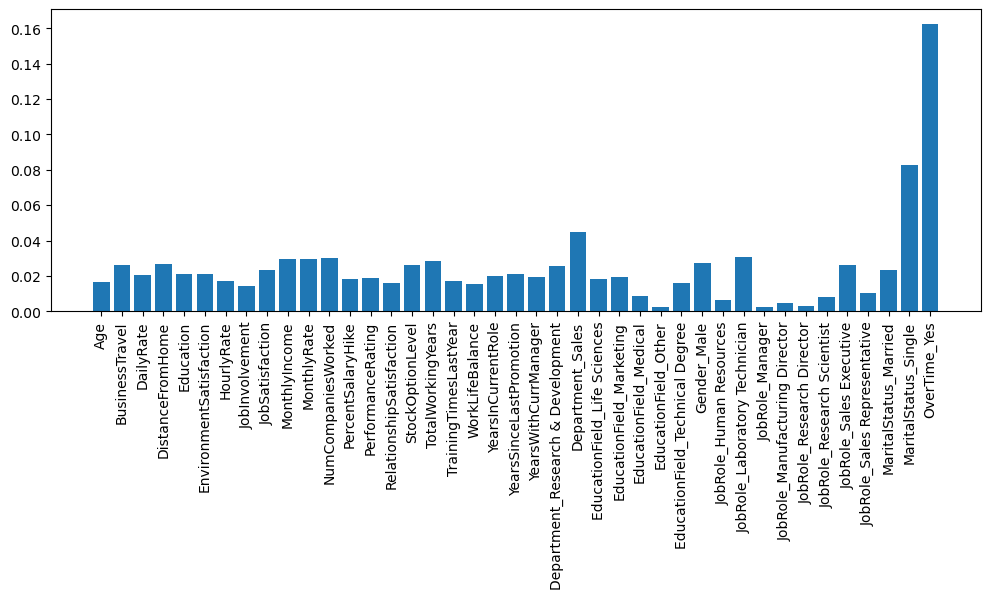

In [19]:
# Let's visualise feature importance

fig, ax = plt.subplots(1,1,figsize=(12,4),dpi=100)

ax.bar(x=list(df_main.drop('Attrition',axis=1).columns),height=random_forest.feature_importances_)
plt.xticks(rotation=90)

plt.show()

In [20]:
# Not a bad first run, now let's tune these hyperparameters

from sklearn.model_selection import GridSearchCV

n_estimators = [100, 300, 500]
max_depth = [2, 3, 8, None]
max_features = ['auto', 'sqrt', 'log2']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]

params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features':max_features, 'min_samples_split':min_samples_split,
         'bootstrap': bootstrap}

random_forest = RandomForestClassifier(random_state=2)

random_forest_cv = GridSearchCV(random_forest, params, scoring = 'roc_auc', n_jobs = -1, cv = None, verbose = 2)

random_forest_cv.fit(X_train_smote, y_train_smote)

print(random_forest_cv.best_params_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}


In [21]:
random_forest_new = RandomForestClassifier(**random_forest_cv.best_params_, random_state = 2)

run_model(random_forest_new)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       306
           1       0.76      0.31      0.44        62

    accuracy                           0.87       368
   macro avg       0.82      0.64      0.68       368
weighted avg       0.86      0.87      0.84       368

CONFUSION MATRIX
[[300   6]
 [ 43  19]]


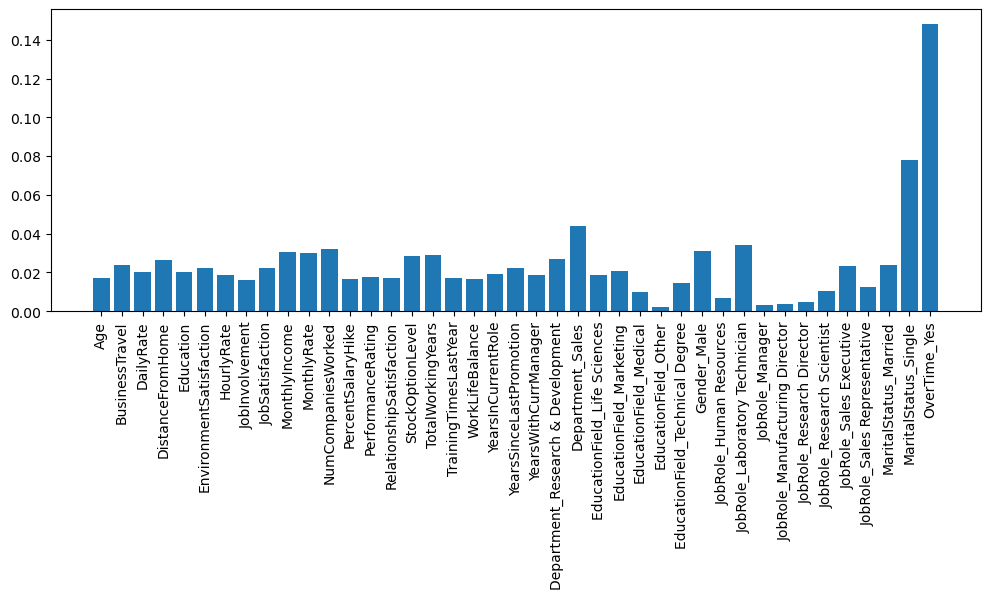

In [22]:
# let's see if the features have changed

fig, ax = plt.subplots(1,1,figsize=(12,4),dpi=100)

ax.bar(x=list(df_main.drop('Attrition',axis=1).columns),height=random_forest_new.feature_importances_)
plt.xticks(rotation=90)

plt.show()

In [23]:
from sklearn.metrics import precision_recall_curve, roc_curve

y_pred = random_forest_new.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

In [24]:
# NEED TO FINISH THIS

### XGBoost

In [25]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

run_model(xgb)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:42:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       306
           1       0.66      0.37      0.47        62

    accuracy                           0.86       368
   macro avg       0.77      0.67      0.70       368
weighted avg       0.84      0.86      0.85       368

CONFUSION MATRIX
[[294  12]
 [ 39  23]]


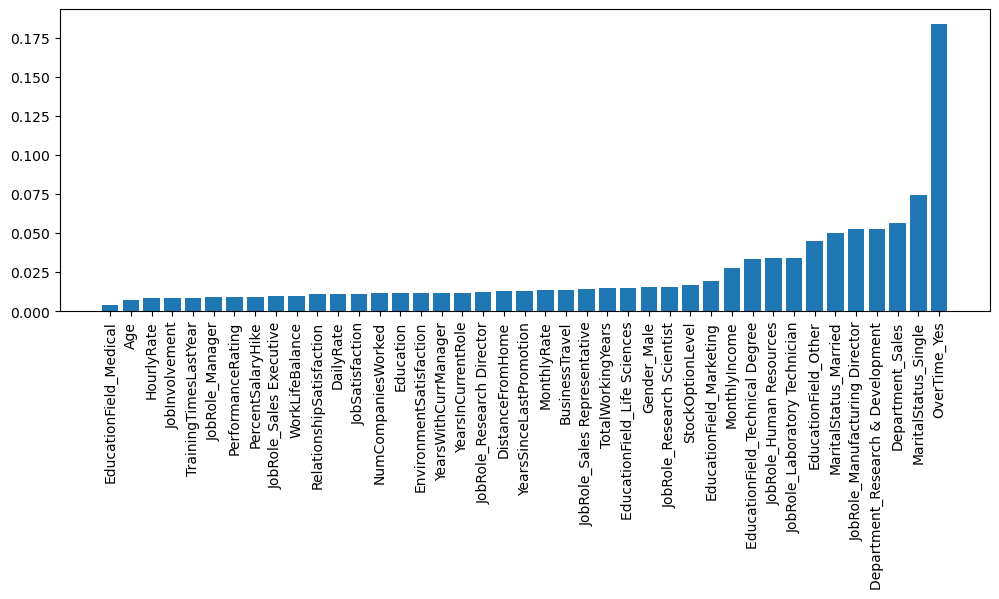

In [26]:
# Create dataframe of results
df_xgb_results = pd.DataFrame()
df_xgb_results['importance'] = xgb.feature_importances_
df_xgb_results['names'] = df_main.drop('Attrition',axis=1).columns
df_xgb_results.set_index('names', inplace=True)
df_xgb_results.sort_values('importance',axis=0,inplace=True)

fig, ax = plt.subplots(1,1,figsize=(12,4),dpi=100)

ax.bar(x=df_xgb_results.index,height=df_xgb_results['importance'])
plt.xticks(rotation=90)

plt.show()

In [27]:
# let's tune these hyperparameters

params = {
        'n_estimators' : [100, 300, 750],
        'learning_rate' : [0.02, 0.05],
        'min_child_weight': [1, 5],
        'gamma': [0.1, 1, 5],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 10]
        }

xgb_gs = GridSearchCV(xgb, params, scoring = 'roc_auc', n_jobs = -1, verbose = 3)

xgb_gs.fit(X_train_smote, y_train_smote)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree...random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                             

In [28]:
xgb_best = XGBClassifier(**xgb_gs.best_params_)

run_model(xgb_best)

[19:04:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       306
           1       0.69      0.32      0.44        62

    accuracy                           0.86       368
   macro avg       0.78      0.65      0.68       368
weighted avg       0.84      0.86      0.84       368

CONFUSION MATRIX
[[297   9]
 [ 42  20]]


### Exporting the Model for Production

In [29]:
xgb_best = XGBClassifier(**xgb_gs.best_params_)

xgb_best.fit(X_train_smote, y_train_smote)

import pickle

pickle.dump(xgb_best, open('model2.pkl','wb'))

[19:04:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
